In [1]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import models, layers, optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.layers import Activation,AveragePooling2D
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

import sklearn
import skimage
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.transform import resize

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import os
from glob import glob
import random
import cv2
import pandas as pd
import numpy as np
import seaborn as sb
import zlib
import itertools
import scipy
import csv
from tqdm import tqdm
%matplotlib inline

Using TensorFlow backend.


In [2]:
IMG_SIZE=50
train_dir = "handgestures/train/"
test_dir =  "handgestures/test/"
def get_data(folder):
    #Load the data and labels from the given folder.
    X = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['K']:
                label = 9
            elif folderName in ['L']:
                label = 10
            elif folderName in ['M']:
                label = 11
            elif folderName in ['N']:
                label = 12
            elif folderName in ['O']:
                label = 13
            elif folderName in ['P']:
                label = 14
            elif folderName in ['Q']:
                label = 15
            elif folderName in ['R']:
                label = 16
            elif folderName in ['S']:
                label = 17
            elif folderName in ['T']:
                label = 18
            elif folderName in ['U']:
                label = 19
            elif folderName in ['V']:
                label = 20
            elif folderName in ['W']:
                label = 21
            elif folderName in ['X']:
                label = 22
            elif folderName in ['Y']:
                label = 23
                
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (IMG_SIZE, IMG_SIZE, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

X_train, y_train = get_data(train_dir) 
X_test, y_test= get_data(test_dir)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2) 

#hot vector labels (1=[0,1,0,0,0,0,0,0,0,0])
y_trainHot = to_categorical(y_train, num_classes = 24)
y_testHot = to_categorical(y_test, num_classes = 24)

100%|██████████| 3000/3000 [00:20<00:00, 145.08it/s]


In [3]:
# Shuffle data for subsampling
X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_train = X_train[:30000]
X_test = X_test[:30000]
y_trainHot = y_trainHot[:30000]
y_testHot = y_testHot[:30000]

C:\ProgramData\Anaconda3\envs\Gradprojectnumpy\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'}


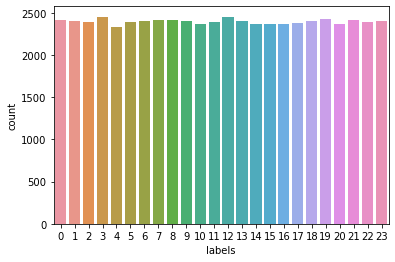

In [4]:
#labels
map_chars = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'}
dict_chars=map_chars
df = pd.DataFrame()
df["labels"]=y_train
label = df['labels']
dist = label.value_counts()
sb.countplot(label)
print(dict_chars)

In [9]:
#Confusion Matrix and curves

class MetricsCheckpoint(Callback):
    #Saves metrics after each epoch.
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def KerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    asd = ['accuracy'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in asd]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    #Prints confusion matrix.
    
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def learning_curve(model_fit):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(model_fit.model_fit['accuracy'])
    plt.plot(model_fit.model_fit['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(model_fit.model_fit['loss'])
    plt.plot(model_fit.model_fit['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

C:\ProgramData\Anaconda3\envs\Gradprojectnumpy\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23], y=[ 5 17 22 ...  8 19 21] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

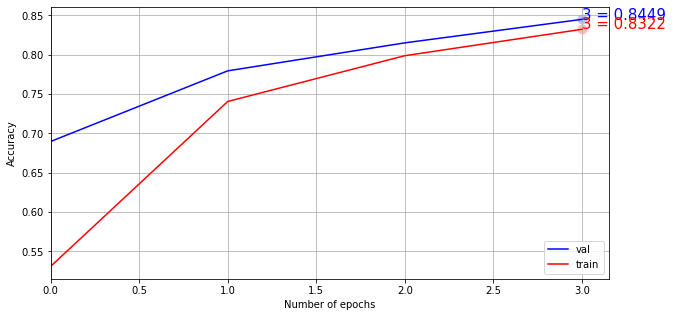

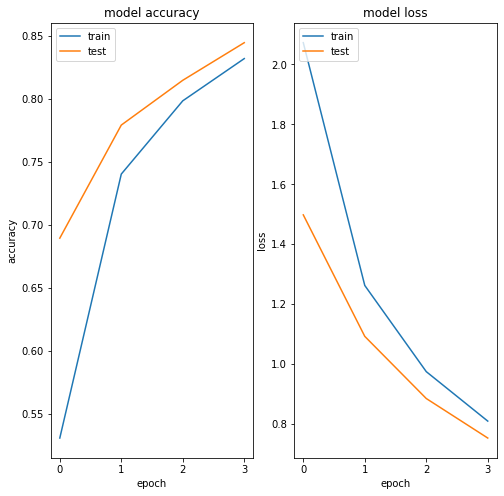

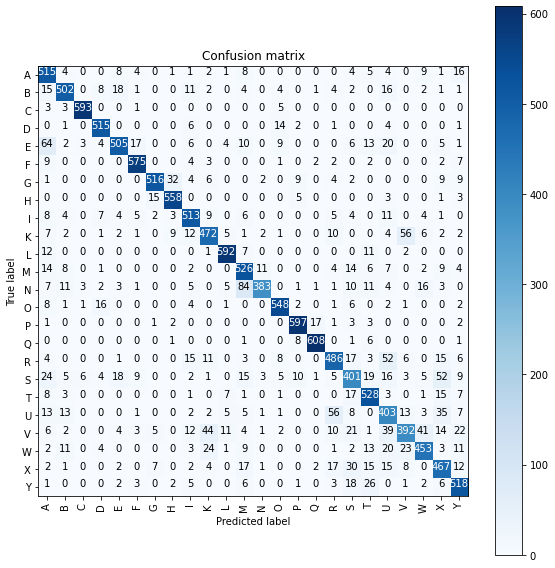

In [11]:
#Model weights with vgg16 model.
#Optained from: 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_chars1 = map_chars
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weight_path1 = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

optimizer1 = keras.optimizers.Adam()
optimizer2 = keras.optimizers.RMSprop(lr=0.0001)

def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
        
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    
    # Fit model
    model_fit = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    KerasLearningCurve()
    plt.show()
    learning_curve(model_fit)
    plt.show()
    confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model

trained_model = pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,24,4,optimizer1,map_chars1)

trained_model.save('modelfinalpls.h5')